# Overfit and Regularisation Exercises

### 0. Tips data EDA (*)

In the whole exercise, we will work with the "tips" dataset from seaborn dataset. Start by loading dataset "tips" from the ```load_dataset``` method in seaborn module. The goal will be to use polynomial linear regression to predict tips. 

&nbsp; a) Start by doing some initial EDA such as info(), describe().

In [314]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ssl
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
ssl._create_default_https_context = ssl._create_unverified_context

In [315]:
tips = sns.load_dataset("tips")

In [316]:
tips.info() # No missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   total_bill  244 non-null    float64 
 1   tip         244 non-null    float64 
 2   sex         244 non-null    category
 3   smoker      244 non-null    category
 4   day         244 non-null    category
 5   time        244 non-null    category
 6   size        244 non-null    int64   
dtypes: category(4), float64(2), int64(1)
memory usage: 7.4 KB


In [317]:
tips.describe()

,total_bill,tip,size
count,244.000000,244.000000,244.000000
mean,19.785943,2.998279,2.569672
std,8.902412,1.383638,0.951100
min,3.070000,1.000000,1.000000
25%,13.347500,2.000000,2.000000
50%,17.795000,2.900000,2.000000
75%,24.127500,3.562500,3.000000
max,50.810000,10.000000,6.000000


In [318]:
tips.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


### Explanation of variables:
total_bill: Total bill (cost of the meal), including tax, in US dollars \
tip: Tip (gratuity) in US dollars \
sex: Sex of person paying for the meal (0=male, 1=female) \
smoker: Smoker in party? (0=No, 1=Yes) \
day: 3=Thur, 4=Fri, 5=Sat, 6=Sun \
time: 0=Day, 1=Night \
size: Size of the party

b) Use describe only on those columns that are relevant to get statistical information from. Plot the descriptive statistics for each numerical column, with a adequate plot type (e.g. barplot).

In [319]:
descriptives = tips.describe().T
descriptives = descriptives.drop(["count"], axis=1)
descriptives = descriptives.rename(index={"total_bill":"Total Bill", "tip":"Tip", "size":"Size"})

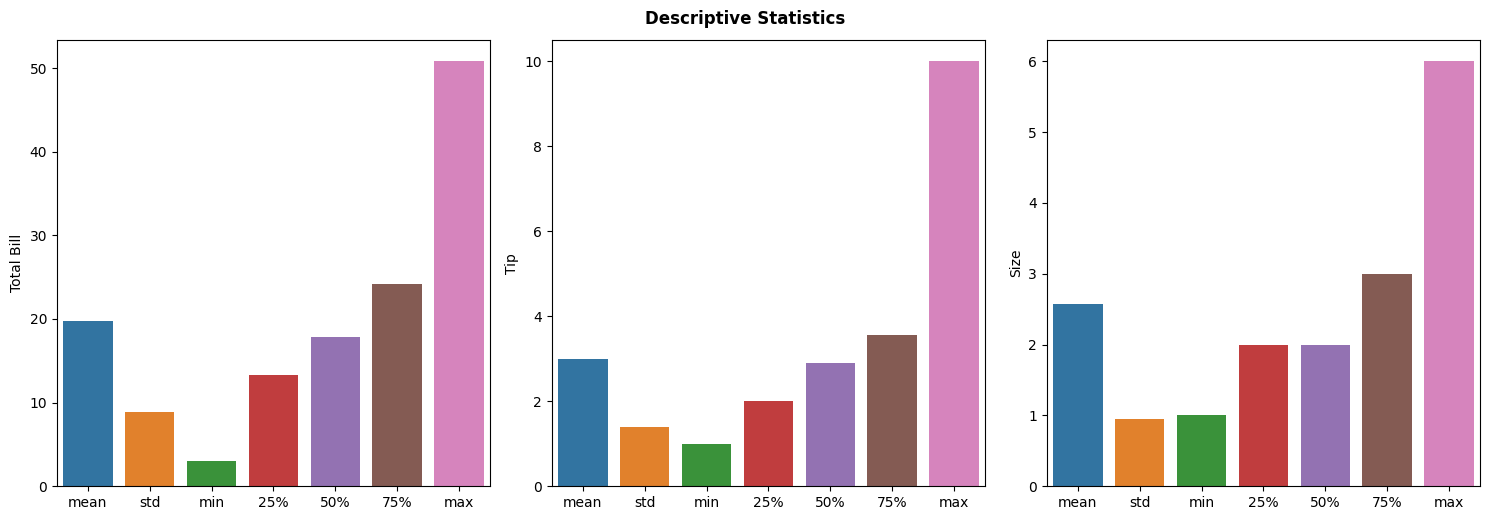

In [320]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), dpi=100)

for i, ax in enumerate(axes):
    sub_fig = sns.barplot(data=descriptives.iloc[[i]], ax=ax)
    ax.set_ylabel(descriptives.index[i])
    
fig.tight_layout()
_ = fig.suptitle("Descriptive Statistics", y=1.03, fontweight="bold")

c) Based on the initial EDA, make some more plots on things you think could be worthwhile to investigate.

Text(0, 0.5, 'Tip')

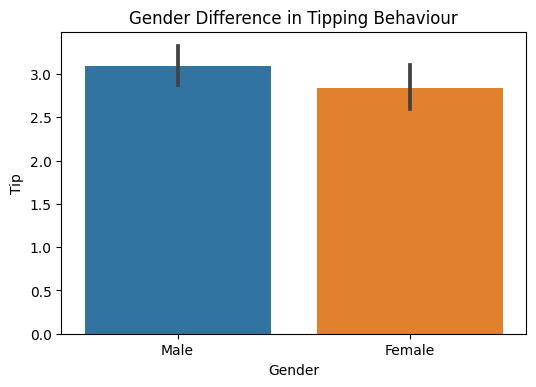

In [321]:
fig, ax = plt.subplots(dpi=100)

sns.barplot(data=tips, x="sex", y="tip")
ax.set_title("Gender Difference in Tipping Behaviour")
ax.set_xlabel("Gender")
ax.set_ylabel("Tip")

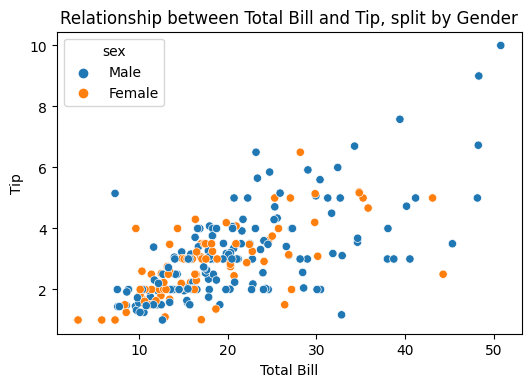

In [322]:
fig, ax = plt.subplots(dpi=100)

sns.scatterplot(data=tips, x="total_bill", y="tip", hue="sex")
ax.set_title("Relationship between Total Bill and Tip, split by Gender")
_ = ax.set_xlabel("Total Bill")
_ = ax.set_ylabel("Tip")

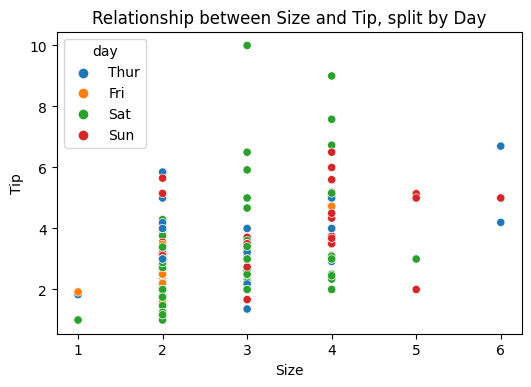

In [323]:
fig, ax = plt.subplots(dpi=100)

sns.scatterplot(data=tips, x="size", y="tip", hue="day")
ax.set_title("Relationship between Size and Tip, split by Day")
_ = ax.set_xlabel("Size")
_ = ax.set_ylabel("Tip")

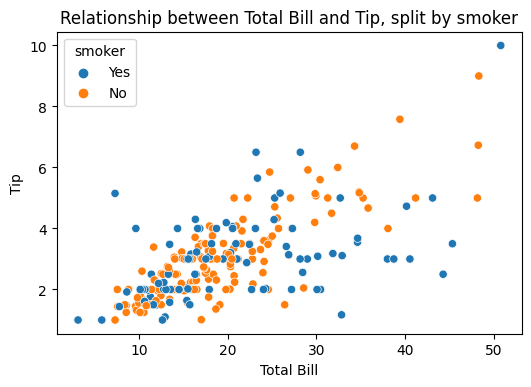

In [324]:
fig, ax = plt.subplots(dpi=100)

sns.scatterplot(data=tips, x="total_bill", y="tip", hue="smoker")
ax.set_title("Relationship between Total Bill and Tip, split by smoker")
_ = ax.set_xlabel("Total Bill")
_ = ax.set_ylabel("Tip")

### 1. Train|test split (*)

Split the data into training part and testing part, using sklearn's train_test_split with test size of 0.3 and random_state 42.

In [325]:
X, y = tips[["total_bill", "size"]], tips["tip"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.3, random_state=42)
    
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((170, 2), (170,), (51, 2), (51,), (23, 2), (23,))

### 2. Feature standardization (*)

We need to normalize the data and in this case will be using feature standardization. Implement this yourself following this formula:

$$X_{train}' = \frac{X_{train}-\mu_{train}}{\sigma_{train}}$$

$$X_{test}' = \frac{X_{test}-\mu_{train}}{\sigma_{train}}$$

, where $'$ denotes scaled, $\mu_{train}$ is the mean of the training data, $\sigma_{train}$ is the standard deviation of the training data. Note that it is very important that the mean and standard deviation is computed from the training data and not from testing data to avoid data leakage. Control the standard deviation and mean of $X_{train}'$ and $X_{test}'$. Is the results as you expect, why, why not?

In [326]:
def standardise(train_data, test_data=None, train=True):

    if train==True:
        train_data_standardised = (train_data - X_train.mean()) / X_train.std()
        return train_data_standardised
    else:
        test_data_standardised = (test_data - X_train.mean()) / X_train.std()
        return test_data_standardised

In [327]:
X_train_stand = standardise(X_train)
X_val_stand = standardise(X_train, X_val, train=False)
X_test_stand = standardise(X_train, X_test, train=False)
X_train_stand

,total_bill,size
234,-0.526512,-0.623676
227,0.015054,1.518241
180,1.578112,1.518241
5,0.547815,1.518241
56,1.947962,1.518241
...,...,...
106,0.019457,-0.623676
14,-0.603564,-0.623676
92,-1.603041,-0.623676
179,1.575911,-0.623676


In [328]:
print(f"Standardised total_bill for training: mean {X_train_stand['total_bill'].mean():.5f}, std {X_train_stand['total_bill'].std():.5f}")
print(f"Standardised size for training: mean {X_train_stand['size'].mean():.5f}, std {X_train_stand['size'].std():.5f}")

print(f"Standardised total_bill for validation: mean {X_val_stand['total_bill'].mean():.5f}, std {X_val_stand['total_bill'].std():.5f}")
print(f"Standardised size for validation: mean {X_val_stand['size'].mean():.5f}, std {X_val_stand['size'].std():.5f}")

print(f"Standardised total_bill for testing: mean {X_test_stand['total_bill'].mean():.5f}, std {X_test_stand['total_bill'].std():.5f}")
print(f"Standardised size for testing: mean {X_test_stand['size'].mean():.5f}, std {X_test_stand['size'].std():.5f}")

Standardised total_bill for training: mean 0.00000, std 1.00000
Standardised size for training: mean -0.00000, std 1.00000
Standardised total_bill for validation: mean -0.10575, std 1.04460
Standardised size for validation: mean 0.06930, std 1.14994
Standardised total_bill for testing: mean -0.38126, std 0.55154
Standardised size for testing: mean -0.29773, std 0.81911


The results are as expected. The training data has a mean very close to 0 and as std very close to 1. The values for validation and testing differs from mean 0 and std 1, since they were standardised using the mean and std of the training data.

Above I used the correct method, with train, test and validation. Below I will repeat this with only train and test so that I can check it against the correct answer for the following exercises.

In [329]:
X, y = tips[["total_bill", "size"]], tips["tip"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [330]:
X_train_stand = standardise(X_train)
X_test_stand = standardise(X_train, X_test, train=False)

print(f"Standardised total_bill for training: mean {X_train_stand['total_bill'].mean():.5f}, std {X_train_stand['total_bill'].std():.5f}")
print(f"Standardised size for training: mean {X_train_stand['size'].mean():.5f}, std {X_train_stand['size'].std():.5f}")

print(f"Standardised total_bill for testing: mean {X_test_stand['total_bill'].mean():.5f}, std {X_test_stand['total_bill'].std():.5f}")
print(f"Standardised size for testing: mean {X_test_stand['size'].mean():.5f}, std {X_test_stand['size'].std():.5f}")

Standardised total_bill for training: mean 0.00000, std 1.00000
Standardised size for training: mean -0.00000, std 1.00000
Standardised total_bill for testing: mean -0.19138, std 0.92496
Standardised size for testing: mean -0.04478, std 1.06639


### 3. Polynomial features (*)

We want to investigate ```Polynomialfeatures``` from scikit-klearn in this task. Start by instantiating an object of type ```PolynomialFeatures``` with degree 2. Now do the following: 

- use the method fit on $X_{train}'$
- transform $X_{train}'$
- transform $X_{test}'$

Compare this transformed $X_{test}'$ with $X_{test}''$ where $X_{test}''$ comes from fitting the polynomial features to $X_{test}'$ and transforming $X_{test}'$. You can check directly by using ```==``` and then sum it up. If the value is same as the length, then you know that they are the same, as a boolean True evaluates to 1. 

In [331]:
model_polynomial = PolynomialFeatures(degree=2, include_bias=False)

poly_features_X_train = model_polynomial.fit_transform(X_train)
poly_features_X_test = model_polynomial.transform(X_test)

test = model_polynomial.fit_transform(X_test)

# Test if equal:
print((poly_features_X_test == test).sum())
print(poly_features_X_test.shape)
# They are the same

370
(74, 5)


### 4. Polynomial regression  (*)

We will now investigate the training loss and testing loss for different degrees of polynomial. Loop through degrees 1 to 4 (inclusive) and:
- instantiate an object of PolynomialFeatures with that degree
- fit and transform $X_{train}'$ and $X_{test}$ to create polynomial features
- perform linear regression on these polynomial features (polynomial regression)
- predict on both the training and testing data to record RMSE for training and testing for each iteration of the loop

Now plot the results in the same figure. Do you notice anything special? 

In [332]:
RMSE_train = []
RMSE_test = []

for degree in range(1, 5):
    model_polynomial = PolynomialFeatures(degree=degree, include_bias=False)
    
    poly_features_X_train = model_polynomial.fit_transform(X_train)
    poly_features_X_test = model_polynomial.transform(X_test)
    
    regression_model = LinearRegression()
    regression_model.fit(poly_features_X_train, y_train)
    
    y_pred_train = regression_model.predict(poly_features_X_train)
    y_pred_test = regression_model.predict(poly_features_X_test)

    RMSE_test.append(np.sqrt(mean_squared_error(y_test, y_pred_test)))    
    RMSE_train.append(np.sqrt(mean_squared_error(y_train, y_pred_train)))

print(RMSE_test)
print(RMSE_train)

[0.918075671288211, 0.9507454245619613, 1.0491866679532114, 2.6976332011822777]
[1.051831600087516, 1.0455263114566506, 0.9834371570521749, 0.9052425871767974]


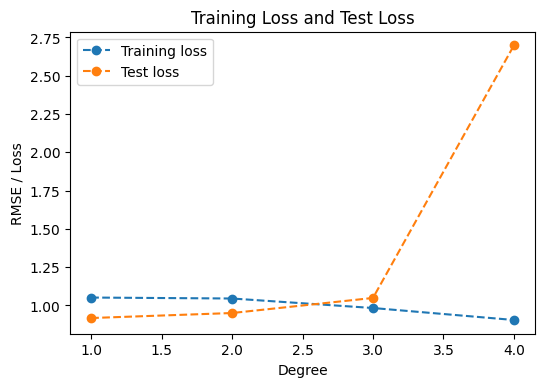

In [333]:
fig, ax = plt.subplots(dpi=100)

plt.plot([1, 2, 3, 4], RMSE_train, "--o", label="Training loss")
plt.plot([1, 2, 3, 4], RMSE_test, "--o", label="Test loss")
ax.set_xlabel("Degree")
ax.set_ylabel("RMSE / Loss")
_ = ax.legend()
_ = ax.set_title("Training Loss and Test Loss")

It seems like a regular linear regression (degree 1) fits the data as good as a polynomial with degree 2 or 3. If we only made our choice based on the training data we might have chosen degree 4 (with the smallest RMSE), but this would result in a very high RMSE for the test data. 

### 5. Regularization methods (*)

Now we will try the regularization methods: ridge regression, lasso regression and elasticnet regression. In the following tasks, use degree = 4. 

&nbsp; a) Use ridge regression with cross-validation and test out different alpha-values. I used $\alpha=[0.01, 0.1, 0.5, 1, 5, 10]$ in the cross-validation. 
- Check which alpha, that the cross-validation chose as the best one. 
- Check the weights.
- Check MAE, MSE, RMSE.

In [334]:
model_polynomial = PolynomialFeatures(degree=4, include_bias=False)

poly_features_X_train = model_polynomial.fit_transform(X_train_stand)
poly_features_X_test = model_polynomial.transform(X_test_stand)

In [335]:
def get_evaluation_metrics(y_test, y_pred):

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    return mae, mse, rmse

In [336]:
model_ridgeCV = RidgeCV(alphas=[0.01, 0.1, 0.5, 1, 5, 10])
model_ridgeCV.fit(poly_features_X_train, y_train)

y_pred_ridge_CV = model_ridgeCV.predict(poly_features_X_test)

mae_ridge, mse_ridge, rmse_ridge = get_evaluation_metrics(y_test, y_pred_ridge_CV)

print(f"Chosen alpha: {model_ridgeCV.alpha_}") 
print(f"MAE: {mae_ridge}")
print(f"MSE: {mse_ridge}")
print(f"RMSE: {rmse_ridge}")
print(f"Weights: {model_ridgeCV.coef_}")

Chosen alpha: 5.0
MAE: 0.830566586741055
MSE: 2.207528610281616
RMSE: 1.485775423905516
Weights: [ 0.91469637  0.23893931 -0.67583593  0.20550801 -0.01369317 -0.26007685
  0.31867863 -0.03429744 -0.12484035  0.16000319 -0.18105113  0.24878399
 -0.12692847  0.05002613]


b) Use lasso regression with cross-validation and choose number of alphas to 100. If you get a warning that the algorithm is not converging, increase the max iterations, I chose 10000 iterations. 
- Check which alpha, that the cross-validation chose as the best one. 
- Check the weights.
- Check MAE, MSE, RMSE.

In [337]:
model_lassoCV = LassoCV(n_alphas=100, max_iter=10000)
model_lassoCV.fit(poly_features_X_train, y_train)

y_pred_lassoCV = model_lassoCV.predict(poly_features_X_test)

mae_lasso, mse_lasso, rmse_lasso = get_evaluation_metrics(y_test, y_pred_lassoCV)

print(f"Chosen alpha: {model_lassoCV.alpha_}")
print(f"MAE: {mae_lasso}")
print(f"MSE: {mse_lasso}")
print(f"RMSE: {rmse_lasso}")
print(f"Weights: {model_lassoCV.coef_}")

Chosen alpha: 0.20770232166587632
MAE: 0.8233993502433836
MSE: 1.3451967151343822
RMSE: 1.159826157290127
Weights: [ 0.23469707  0.         -0.         -0.          0.          0.08814685
  0.09735986  0.          0.03219702  0.          0.          0.
 -0.          0.        ]


c) Use elasticnet regression with cross-validation and choose number of alphas to 100. If you get a warning that the algorithm is not converging, increase the max iterations, I chose 10000 iterations. Choose a set of $\ell_1$ ratios for it to try out. I chose $\ell_1 = [.001, .01, .05, .1, .5, .9, .95, 1]$
- Check which alpha, that the cross-validation chose as the best one. 
- Check the weights.
- Check MAE, MSE, RMSE.

In [338]:
model_elastic = ElasticNetCV(l1_ratio=[.001, .01, .05, .1, .9, .95, 1], n_alphas=100, max_iter=10000)
model_elastic.fit(poly_features_X_train, y_train)

y_pred_elastic = model_elastic.predict(poly_features_X_test)

mae_elastic, mse_elastic, rmse_elastic = get_evaluation_metrics(y_test, y_pred_elastic)

print(f"Chosen alpha {model_elastic.alpha_}")
print(f"L1 ratio {model_elastic.l1_ratio_}")
print(f"MAE: {mae_elastic}")
print(f"MSE: {mse_elastic}")
print(f"RMSE: {rmse_elastic}")
print(f"Weights: {model_elastic.coef_}")

Chosen alpha 0.10711875299553128
L1 ratio 0.9
MAE: 0.7608143757323664
MSE: 1.298344688539288
RMSE: 1.1394492917805898
Weights: [ 0.51936778  0.09958848 -0.21441971  0.          0.          0.
  0.11409441  0.          0.01801213  0.03754525  0.          0.
  0.          0.        ]
